# Making the Parametrized Expectations Algorithm Parallel 
## (IN PROGRESS)

In [2]:
include("matrixPrint.jl")

# Set parameters:

alpha  = 0.33;
beta   = 0.99;
sigma  = 1.5;
delta  = 0.025;
sigmae = 0.02;
rho    = 0.9; 
T      = 10000;  

# Steady States:

kbar = ( (1-beta*(1-delta))/(alpha*beta) )^(1/(alpha-1));  # steady-state capital
cbar = kbar^alpha - delta*kbar;                            # steady-state consumption

### PEA with Moving Bounds (CPU)

In [3]:
using Optim
using Alistair

tet = zeros(T);     # technology shocks
k   = zeros(T+1);   # capital
c   = zeros(T);     # consumption
phi = zeros(T-1);   # conditional expectation

k[1]    = kbar;              # initial value of capital (steady state)
tet[1]  = 1;                 # initial value of shock   (steady state)
epsilon = randn(T)*sigmae;   # draw sequence of shocks

for t = 2:T  
  tet[t] = tet[t-1]^rho * exp(epsilon[t]);  
end

#pea_formula = @formula(Y ~ log(X1) + log(X2));

In [72]:
# Coefficients from log-linearized policy rules (Dynare):

gammas = [log(cbar^(-1/sigma)*(1-delta+alpha*kbar^(alpha-1))); 0; 0];

# Moving bounds function:
#mbf(n) = 0.2 * (exp(0.5 * n) - 1);
mbf(n) = (atan(n / 2 - 5) + 1.456) * n 
mbf_it = 0;

crit         = 1e-4;   # convergence criterion
update       = 0.90;   # updating parameter for homotopy
iteration    = 1;
dif          = 1;
max_bound_it = 25;

# Impose a cut-off:
maxit = 500;
# -> There is no certainty of convergence for the PEA method...

g = zeros(length(gammas), maxit);

tic()

while dif > crit && iteration <= maxit
    
    mb_flag = mbf(iteration) < max_bound_it;
    if mb_flag
        mbf_it = mbf_it + 1;
    end
    
    for t = 1:T
        uprime = exp(gammas[1] + gammas[2]*log(k[t]) + gammas[3]*log(tet[t]));
        c[t]   = (beta * uprime)^(-1/sigma);
    
        k__    = tet[t] * k[t]^alpha + (1-delta)*k[t] - c[t];
        if mb_flag
            k[t+1] = max((kbar - mbf(iteration)), min(k__, (kbar + mbf(iteration))));
        else
            k[t+1] = k__;
        end
    
    end

    for t in 1:T-1
        phi[t] = c[t+1]^(-sigma) * (1-delta + alpha*tet[t+1]*k[t+1]^(alpha-1));
    end

    #x = DataFrame(X1=log.(k[1:T-1]), X2=log.(tet[1:T-1]), Y=phi);  # regressors 
    x_ = [ones(T-1,1) log.(k[1:T-1]) log.(tet[1:T-1])]
  
    #fit = curve_fit(pea_f, x, phi, gammas);
    #fitted = glm(@formula(Y ~ X1 * X2), x, Normal(), IdentityLink())
    #gammas1 = Array(coef(fitted)')
    #= Function for the PEA:
    pea_f(gamma_) = exp.(gamma_[1] + gamma_[2]*log.(x_[1]) + gamma_[3]*log.(x_[2]));

    fitted = optimize(pea_f, gammas, BFGS())
    =#

    gammas1 = ols_linfit(x_, log.(phi)).beta

    dif = maximum(abs.(gammas1 - gammas))          # convergence metrix
  
    gammas = update*gammas1 + (1-update)*gammas   # update coefficients
    g[:, iteration] = gammas[:]
    
    #println(iteration, ", ", gammas)
  
    iteration += 1  # update counter

end

time_cpu = toc()

println("\n ɣ = ", gammas1)

elapsed time: 3.605037285 seconds

 ɣ = [1.30915, -0.762509, -0.352635]


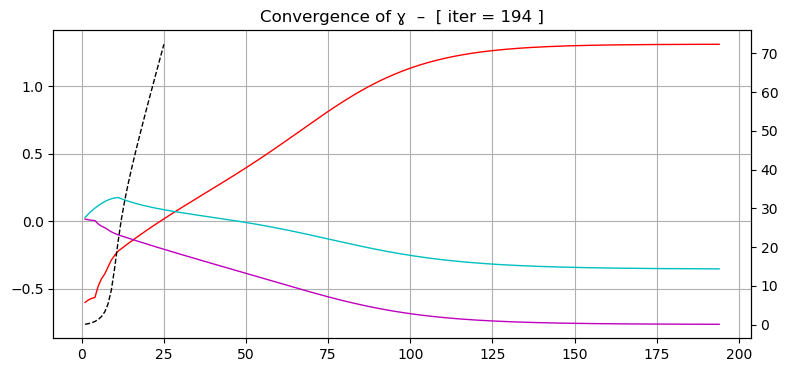

In [73]:
using PyPlot;

fig = figure(figsize=(9,4));
ax_1 = subplot(111);
ax_1[:plot](1:iteration-1, g[1,1:iteration-1], "r-", linewidth=1);
ax_1[:plot](1:iteration-1, g[2,1:iteration-1], "m-", linewidth=1);
ax_1[:plot](1:iteration-1, g[3,1:iteration-1], "c-", linewidth=1);
ax_b1 = twinx(ax_1)
ax_b1[:plot](1:max_bound_it, mbf.(collect(1:max_bound_it)), "k--", linewidth=1);
ax_1[:grid](true);
#ylabel("V(k)")
#xlabel("k")
title("Convergence of ɣ  –  [ iter = $(iteration-1) ]");